# Data pre-processing

## TODOs longterm:
* include the different product types which are relevant for mode shift

In [1]:
# case setting 
case = 1 # 1, 2, 3, 4

In [2]:
import sys
sys.path.append('.')
from preprocessing_fix_for_nuts3 import (
    create_nuts3_paths_from_traffic,
    create_simplified_spatial_flexibility
)

Rules: network_cost, elec_price
Case 1: const, const
Case 2: diff, const
Case 3: const, diff
Case 4: diff, diff

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import Geod

In [4]:
# resolution = "original"
resolution = "reduced"

if resolution == "original":
    folder = "data/Trucktraffic/"
else:
    folder = "data/Trucktraffic_NUTS3/"

In [5]:
# Nuts regions 
nuts_regions = gpd.read_file("data/NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp")
print(nuts_regions.keys())

Index(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry'],
      dtype='object')


## Step 1: Definition of regions within SM corridor

In [6]:
# loading the dataset 
nuts_3_to_nodes = pd.read_csv(folder + "02_NUTS-3-Regions.csv")

# filter rule 
nuts_to_filter_for = { "NUTS_0": ["DE", "DK"],
                      
                        "NUTS_1": ["SE1", "SE2", "AT3", "ITC", "ITH", "ITI", "ITF"],
                      "NUTS_2": ["SE11", "SE12", "SE21", "SE22", "NO08", "NO09","NO02", "NO0A"],}

## Step 2: Filtering route set for relevant routes

In [7]:
for level, nuts_list in nuts_to_filter_for.items():
    missing = [nuts for nuts in nuts_list if nuts not in nuts_regions['NUTS_ID'].values]
    print(f"Missing {level} codes in NUTS_ID: {missing}")

Missing NUTS_0 codes in NUTS_ID: []
Missing NUTS_1 codes in NUTS_ID: []
Missing NUTS_2 codes in NUTS_ID: []


In [8]:
from shapely import wkt

# Filter nuts_regions for the selected NUTS_2 codes
filtered_nodes_by_level = {}

# Convert nuts_3_to_nodes to a GeoDataFrame if not already done
if 'nuts_3_to_nodes_gdf' not in locals():
    nuts_3_to_nodes_gdf = gpd.GeoDataFrame(
        nuts_3_to_nodes,
        geometry=nuts_3_to_nodes['Geometric_center'].apply(wkt.loads),
        crs=nuts_regions.crs
    )

for level, nuts_list in nuts_to_filter_for.items():
    selected_polygons = nuts_regions[nuts_regions['NUTS_ID'].isin(nuts_list)]
    filtered_nodes = gpd.sjoin(nuts_3_to_nodes_gdf, selected_polygons, predicate='within')
    filtered_nodes_by_level[level] = filtered_nodes

# Show the filtered nodes for each level
# for level, df in filtered_nodes_by_level.items():
#     print(f"Filtered nodes for {level}:")
#     print(df)

# Concatenate all filtered nodes into a single GeoDataFrame
all_filtered_nodes = gpd.GeoDataFrame(
    pd.concat(filtered_nodes_by_level.values(), ignore_index=True),
    crs=nuts_3_to_nodes_gdf.crs
)
print(len(all_filtered_nodes))

585


In [9]:
network_nodes = pd.read_csv(folder + "03_network-nodes.csv")
network_edges = pd.read_csv(folder + "04_network-edges.csv")


# Filter network_nodes for ETISplus_Zone_ID values present in all_filtered_nodes
filtered_network_nodes = network_nodes[network_nodes['ETISplus_Zone_ID'].isin(all_filtered_nodes['ETISPlus_Zone_ID'])]

print(filtered_network_nodes.head())
print(len(filtered_network_nodes))

filtered_node_ids = set(filtered_network_nodes['Network_Node_ID'])
filtered_network_edges = network_edges[
    network_edges['Network_Node_A_ID'].isin(filtered_node_ids) &
    network_edges['Network_Node_B_ID'].isin(filtered_node_ids)
]

print(filtered_network_edges.head())
print(len(filtered_network_edges))


     Network_Node_ID  Network_Node_X  Network_Node_Y  ETISplus_Zone_ID Country
405           108492         6.09583         50.7598         107100201      DE
409           196402         6.17193         51.0442         107100209      DE
411           121718         6.21743         59.0615         125000403      NO
414           111714         6.23823         50.7222         107100205      DE
415           196550         6.23987         51.6305         107100111      DE
573
    Network_Edge_ID  Manually_Added  Distance  Network_Node_A_ID  \
33               33               0    11.077             202005   
34               34               0     2.604             202005   
36               36               0     3.161             197964   
37               37               0     6.546             197964   
39               39               0     5.494             100129   

    Network_Node_B_ID  Traffic_flow_trucks_2019  Traffic_flow_trucks_2030  
33             197964                

In [10]:
truck_traffic = pd.read_csv(folder + "01_Trucktrafficflow.csv")
# Convert the string representation of lists to actual lists of integers
truck_traffic['Edge_path_E_road'] = truck_traffic['Edge_path_E_road'].apply(lambda x: [int(i) for i in x.strip('[]').split(',') if i.strip().isdigit()])

# Get the set of filtered Network_Edge_IDs
filtered_edge_ids = set(filtered_network_edges['Network_Edge_ID'])

# Keep only rows where all edges in Edge_path_E_road are in filtered_edge_ids
def all_edges_in_filtered(edge_list):
    return all(e in filtered_edge_ids for e in edge_list)

filtered_truck_traffic = truck_traffic[truck_traffic['Edge_path_E_road'].apply(all_edges_in_filtered)].copy()

In [11]:
print(len(filtered_truck_traffic))
print(filtered_truck_traffic.head())

70
        ID_origin_region Name_origin_region  ID_destination_region  \
405040         107090104            Gifhorn              107090304   
425421         107090304  Luchow-Dannenberg              107090104   
737605         110070003          El Hierro              110070005   
737606         110070003          El Hierro              110070006   
737607         110070003          El Hierro              110070007   

       Name_destination_region  Traffic_flow_trucks_2010  \
405040       Luchow-Dannenberg                    672.50   
425421                 Gifhorn                    467.50   
737605            Gran Canaria                      1.25   
737606               La Gomera                    533.75   
737607                La Palma                   8101.25   

        Traffic_flow_trucks_2019  Traffic_flow_trucks_2030  \
405040                    806.25                   1007.50   
425421                    561.25                    700.00   
737605                      2

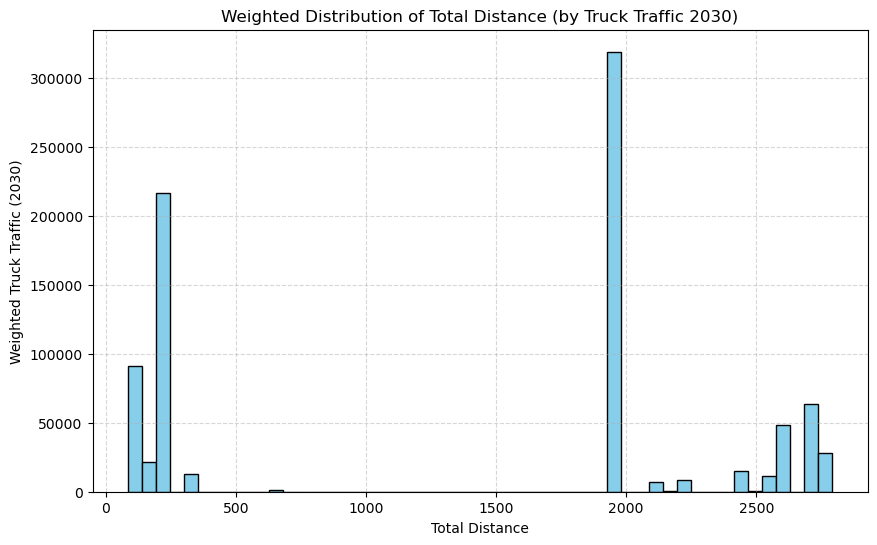

Average: 1547.26, Min: 84.00, Max: 2792.00


In [12]:
filtered_truck_traffic['Total_distance'] = (
    filtered_truck_traffic['Distance_from_origin_region_to_E_road'] +
    filtered_truck_traffic['Distance_within_E_road'] +
    filtered_truck_traffic['Distance_from_E_road_to_destination_region']
)
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_truck_traffic['Total_distance'],
    bins=50,
    weights=filtered_truck_traffic['Traffic_flow_trucks_2030'],
    color='skyblue',
    edgecolor='black'
)
plt.xlabel('Total Distance')
plt.ylabel('Weighted Truck Traffic (2030)')
plt.title('Weighted Distribution of Total Distance (by Truck Traffic 2030)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
avg = filtered_truck_traffic['Total_distance'].mean()
min_val = filtered_truck_traffic['Total_distance'].min()
max_val = filtered_truck_traffic['Total_distance'].max()
print(f"Average: {avg:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

## Step 3: Mapping to relevant NUTS-2 regions

substeps:
3.1 getting relevant NUTS-2 regions -- check
3.2 cutting routes to relevant regions 
3.3 mapping from NUTS-3 to NUTS-2 

### Step 3.2.: getting relevant NUTS-2 regions

In [13]:
print(nuts_regions.keys())

Index(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry'],
      dtype='object')


In [14]:
# Collect all relevant NUTS_IDs from nuts_to_filter_for
relevant_codes = []
for codes in nuts_to_filter_for.values():
    relevant_codes.extend(codes)

# Filter nuts_regions for LEVL_CODE == 2 and NUTS_ID containing any relevant code
mask = (nuts_regions['LEVL_CODE'] == 3) & (
    nuts_regions['NUTS_ID'].apply(lambda x: any(code in x for code in relevant_codes))
)
relevant_nuts_regions = nuts_regions[mask]
print(relevant_nuts_regions[['NUTS_ID', 'NUTS_NAME']])

     NUTS_ID                    NUTS_NAME
322    DE254   Nürnberg, Kreisfreie Stadt
323    DE255  Schwabach, Kreisfreie Stadt
324    DE256           Ansbach, Landkreis
325    DE257           Erlangen-Höchstadt
402    DE258             Fürth, Landkreis
...      ...                          ...
1668   SE212               Kronobergs län
1669   SE213                   Kalmar län
1670   SE214                 Gotlands län
1671   SE221                 Blekinge län
1672   SE224                    Skåne län

[542 rows x 2 columns]


In [15]:
# Create a mapping from Network_Edge_ID to Distance for filtered_network_edges
edge_distance_map = dict(zip(filtered_network_edges['Network_Edge_ID'], filtered_network_edges['Distance']))

def reduce_route_and_distance(edge_list):
    # Keep only edges that are in filtered_edge_ids
    reduced_route = [e for e in edge_list if e in filtered_edge_ids]
    # Calculate the total distance for the reduced route
    reduced_distance = sum(edge_distance_map.get(e, 0) for e in reduced_route)
    return pd.Series({'Reduced_Edge_path': reduced_route, 'Reduced_Distance': reduced_distance})

# Apply the function to filtered_truck_traffic
filtered_truck_traffic[['Reduced_Edge_path', 'Reduced_Distance']] = filtered_truck_traffic['Edge_path_E_road'].apply(reduce_route_and_distance)

# Show a sample of the new columns
# network_cost_value[['Edge_path_E_road', 'Reduced_Edge_path', 'Reduced_Distance']].head()     


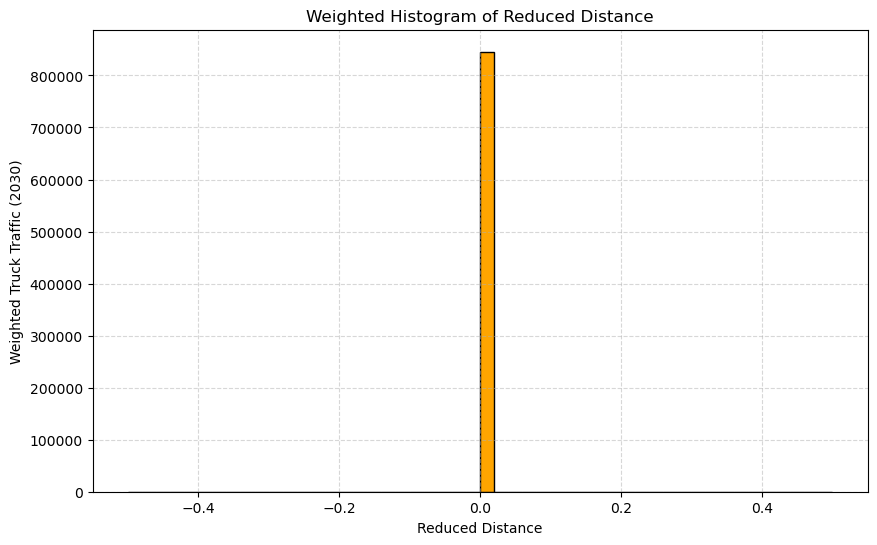

70


In [16]:
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_truck_traffic['Reduced_Distance'],
    bins=50,
    weights=filtered_truck_traffic['Traffic_flow_trucks_2030'],
    color='orange',
    edgecolor='black'
)
plt.xlabel('Reduced Distance')
plt.ylabel('Weighted Truck Traffic (2030)')
plt.title('Weighted Histogram of Reduced Distance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print(len(filtered_truck_traffic))                                                                                                                                                        

__What do I need as input data?__

* TechVehicle (check)
* VehicleType (check)
* Modes(check)
* Technology (check)
* Fuel (check)
* Product types (check)
* Regiontype (check)
* Speed (check)
* InititalModeInfr (check)
* InititalFuelingInfr (check)
* Odpair (check)
* Path (check)
* GeographicElement (check)
* Model Params
* InititalVehicleStock (check) 
* FinancialStatus (only one indicating frequency of new purchases) (check)
* MaximumFuelingCapacityByType 
* FuelingInfrTypes (check)
* MaximumFuelingCapacityByTypeByYear

In [17]:
Y = 21
prey_y = 10
G = Y + prey_y
y_init = 2020
g_init = y_init - prey_y
Y_end = y_init + Y
print(y_init, Y, prey_y, Y_end, G, g_init)



2020 21 10 2041 31 2010


### Preparing demand side parameters

Main assumptions:
* electrification of interregional road freight is currently 0 
* current assumption: constant transport demand values for road freight
* long-haul is: > 350km

In [18]:
long_haul_truck_traffic = filtered_truck_traffic[filtered_truck_traffic['Reduced_Distance'] >= 1000].copy()
print(len(long_haul_truck_traffic))
long_haul_truck_traffic.head()

0


,ID_origin_region,Name_origin_region,ID_destination_region,Name_destination_region,Traffic_flow_trucks_2010,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030,Traffic_flow_tons_2010,Traffic_flow_tons_2019,Traffic_flow_tons_2030,Distance_from_origin_region_to_E_road,Distance_within_E_road,Distance_from_E_road_to_destination_region,Edge_path_E_road,Total_distance,Reduced_Edge_path,Reduced_Distance


In [19]:
 # Filter for international routes only
# Map ETISplus Zone IDs to countries using filtered_network_nodes
zone_to_country = dict(zip(filtered_network_nodes['ETISplus_Zone_ID'], filtered_network_nodes['Country']))

# Add origin and destination countries
long_haul_truck_traffic['origin_country'] = long_haul_truck_traffic['ID_origin_region'].map(zone_to_country)
long_haul_truck_traffic['destination_country'] = long_haul_truck_traffic['ID_destination_region'].map(zone_to_country)

# Filter for international routes (origin country != destination country)
international_routes = long_haul_truck_traffic[
    long_haul_truck_traffic['origin_country'] != long_haul_truck_traffic['destination_country']
].copy()

print(f"Long-haul routes (>= 350 km): {len(long_haul_truck_traffic)}")
print(f"International long-haul routes: {len(international_routes)}")
print(f"Domestic long-haul routes filtered out: {len(long_haul_truck_traffic) - len(international_routes)}")

# Replace long_haul_truck_traffic with international routes
long_haul_truck_traffic = international_routes

Long-haul routes (>= 350 km): 0
International long-haul routes: 0
Domestic long-haul routes filtered out: 0


In [20]:
import numpy as np

carbon_price = {2018: 15.06, 2020: 30, 2025: 51.5871, 2030: 76.4254, 2035: 113.223, 2040: 167.737, 2045:248.5, 2050: 355}


def interpolate_carbon_price(year, carbon_price_dict):
    """
    Interpolates the carbon price for a given year based on a dictionary of defined values.

    :param year: The year for which to interpolate the carbon price.
    :param carbon_price_dict: A dictionary with years as keys and carbon prices as values.
    :return: The interpolated carbon price for the given year.
    """
    years = np.array(list(carbon_price_dict.keys()))
    prices = np.array(list(carbon_price_dict.values()))
    
    if year < years.min():
        # Extrapolate for years before the minimum defined year
        slope = (prices[1] - prices[0]) / (years[1] - years[0])
        return prices[0] + slope * (year - years[0])
    elif year > years.max():
        # Extrapolate for years after the maximum defined year
        slope = (prices[-1] - prices[-2]) / (years[-1] - years[-2])
        return prices[-1] + slope * (year - years[-1])
    else:
        # Interpolate for years within the defined range
        return np.interp(year, years, prices)

# Example usage
print(interpolate_carbon_price(2023, carbon_price))
carbon_price_dict = {year: interpolate_carbon_price(year, carbon_price) for year in range(2020, 2062)}

42.95226


In [21]:
# creating geographic_elements - ONE PER NETWORK NODE (optimized)
geographic_elements = []

# Pre-calculate carbon prices once
carbon_prices = [float(carbon_price_dict[year+y_init]) for year in range(Y)]

for index, row in filtered_network_nodes.iterrows():
    geographic_elements.append({
        "id": int(row['Network_Node_ID']),
        "type": "node",
        "name": f"node_{int(row['Network_Node_ID'])}",
        "nuts3_region": row['ETISplus_Zone_ID'],
        "country": row['Country'],
        "carbon_price": carbon_prices,  # Reuse same list
        "from": 999999,
        "to": 999999,
        "length": 0.0,
        "coordinate_lat": row['Network_Node_Y'],
        "coordinate_long": row['Network_Node_X'],
    })

# Create mapping dictionaries for fast lookups
node_id_to_geo = {int(row['Network_Node_ID']): {
    'id': int(row['Network_Node_ID']),
    'country': row['Country'],
    'nuts3': row['ETISplus_Zone_ID'],
    'coords': (row['Network_Node_X'], row['Network_Node_Y'])
} for _, row in filtered_network_nodes.iterrows()}

print(f"Number of geographic elements: {len(geographic_elements)}")
print(f"Created lookup dictionary with {len(node_id_to_geo)} entries")

Number of geographic elements: 573
Created lookup dictionary with 555 entries


In [22]:
# This function is no longer needed - network nodes ARE geographic elements now!
# Keeping for backwards compatibility but it just returns the node IDs

def map_nodes_to_geo_ids(network_node_ids):
    """
    Map network node IDs to GeographicElement IDs.
    Since we now use network nodes as geo elements, this is a direct mapping.
    """
    return network_node_ids  # Direct mapping!

print("Network nodes are now geographic elements - no mapping needed!")

Network nodes are now geographic elements - no mapping needed!


In [23]:
def get_nodes_along_path(edge_path, edge_df):
    """
    Optimized: Returns a list of node IDs traversed along a connected path of edges.
    """
    if not edge_path:
        return []

    # Pre-filter relevant edges and build lookup dict
    path_edges_df = edge_df[edge_df['Network_Edge_ID'].isin(edge_path)]
    edge_map = {
        int(row['Network_Edge_ID']): (int(row['Network_Node_A_ID']), int(row['Network_Node_B_ID']))
        for _, row in path_edges_df.iterrows()
    }

    if not edge_path or edge_path[0] not in edge_map:
        return []

    # Build path starting from both ends and pick the best
    first_edge = edge_path[0]
    node_a, node_b = edge_map[first_edge]
    
    nodes_a = build_path_from_node(node_a, edge_path, edge_map)
    nodes_b = build_path_from_node(node_b, edge_path, edge_map)
    
    return nodes_a if len(nodes_a) >= len(nodes_b) else nodes_b

def build_path_from_node(start_node, edge_path, edge_map):
    """Optimized: Build connected path from start node"""
    nodes = [start_node]
    current = start_node
    used_edges = set()
    
    for edge_id in edge_path:
        if edge_id not in edge_map or edge_id in used_edges:
            continue
        
        a, b = edge_map[edge_id]
        
        if current == a:
            nodes.append(b)
            current = b
            used_edges.add(edge_id)
        elif current == b:
            nodes.append(a)
            current = a
            used_edges.add(edge_id)
        # If edge doesn't connect, skip it (don't break - might connect later)
    
    return nodes

def validate_connected_sequence(nodes, edge_df):
    """
    Validates that all consecutive node pairs in the sequence are actually connected by edges.
    Returns only the longest connected subsequence.
    """
    if len(nodes) < 2:
        return nodes
    
    # Build edge lookup for validation
    edge_set = set()
    for _, row in edge_df.iterrows():
        a, b = int(row['Network_Node_A_ID']), int(row['Network_Node_B_ID'])
        edge_set.add((a, b))
        edge_set.add((b, a))
    
    # Find longest connected subsequence
    connected_sequences = []
    current_seq = [nodes[0]]
    
    for i in range(len(nodes) - 1):
        node_from = nodes[i]
        node_to = nodes[i + 1]
        
        if (node_from, node_to) in edge_set:
            current_seq.append(node_to)
        else:
            # Disconnected - save current sequence and start new one
            if len(current_seq) > 1:
                connected_sequences.append(current_seq)
            current_seq = [node_to]
    
    # Don't forget last sequence
    if len(current_seq) > 1:
        connected_sequences.append(current_seq)
    
    # Return longest connected sequence
    if connected_sequences:
        return max(connected_sequences, key=len)
    else:
        return nodes[:1]  # Return just first node if no connections found

def sort_nodes_by_path_sequence(nodes_list, origin_id, destination_id, filtered_network_nodes):
    """
    Optimized: Sort nodes by distance from origin to destination using vectorized operations
    """
    if not nodes_list:
        return []
    
    # Get origin/dest coordinates
    origin_row = filtered_network_nodes[filtered_network_nodes['ETISplus_Zone_ID'] == origin_id]
    dest_row = filtered_network_nodes[filtered_network_nodes['ETISplus_Zone_ID'] == destination_id]
    
    if origin_row.empty or dest_row.empty:
        return nodes_list
    
    origin_coord = (origin_row.iloc[0]['Network_Node_X'], origin_row.iloc[0]['Network_Node_Y'])
    dest_coord = (dest_row.iloc[0]['Network_Node_X'], dest_row.iloc[0]['Network_Node_Y'])
    
    # Get coordinates for all nodes in the list
    nodes_df = filtered_network_nodes[filtered_network_nodes['Network_Node_ID'].isin(nodes_list)].copy()
    
    if nodes_df.empty:
        return nodes_list
    
    # Vectorized distance calculation
    from pyproj import Geod
    geod = Geod(ellps="WGS84")
    
    # Calculate sort key for all nodes at once
    def calc_sort_key(row):
        _, _, d_orig = geod.inv(origin_coord[0], origin_coord[1], row['Network_Node_X'], row['Network_Node_Y'])
        _, _, d_dest = geod.inv(dest_coord[0], dest_coord[1], row['Network_Node_X'], row['Network_Node_Y'])
        return d_orig - d_dest
    
    nodes_df['sort_key'] = nodes_df.apply(calc_sort_key, axis=1)
    sorted_df = nodes_df.sort_values('sort_key')
    
    return sorted_df['Network_Node_ID'].tolist()

In [24]:
financial_status_list = [
    {   "id": 0,
        "name": "any",
        "VoT": 0.0,
        "monetary_budget_operational": 0.0,
        "monetary_budget_operational_lb": 0.0,
        "monetary_budget_operational_ub": 0.0,
        "monetary_budget_purchase": 0.0,
        "monetary_budget_purchase_lb": 0.0,
        "monetary_budget_purchase_ub": 0.0,
        "monetary_budget_purchase_time_horizon": 1,
        "average_household_size": 2.4,
     },
]


In [25]:
technologies = ["ICEV", "BEV"]
factors = 1
subsidy = 20000
added_fact = 1
capital_cost_dict = {
    "ICEV": {2020: 105484 * added_fact, 2025: 109159 * added_fact, 2030: 115252 * added_fact, 2040: 115252 * added_fact, 2050: 115252 * added_fact},
    "BEV": {2020: (417255- subsidy)*factors, 2025: (200006- subsidy)*factors, 2030: (145346- subsidy)*factors, 2040: (145346- subsidy)*factors, 2050: (145346- subsidy)*factors},
}
vehicle_tax_ICEV = 561
vehicle_tax_BEV = 5
maintenance_annual_cost_dict = {
    "ICEV": {2020: 20471 + vehicle_tax_ICEV, 2025: 20608 + vehicle_tax_ICEV, 2030: 20608 + vehicle_tax_ICEV, 2040: 20608 + vehicle_tax_ICEV, 2050: 20608 + vehicle_tax_ICEV},
    "BEV": {2020: 14359 + vehicle_tax_BEV, 2050: 14359 + vehicle_tax_BEV},
}

L_to_kWh = 9.7  # kWh per litre of diesel
fuel_economy_dict = {
    "ICEV": {2020: 29.86 * L_to_kWh, 2025: 26.67 * L_to_kWh, 2030: 23.47 * L_to_kWh, 2040: 23.47* L_to_kWh, 2050: 23.47*L_to_kWh},  # in kWh/km
    "BEV": {2020: 1.60, 2025: 1.41, 2030: 1.21, 2040: 1.21, 2050: 1.21},  # in kWh/km
}

maintenance_distance_dict = {
    "ICEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
    "BEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
}


fuel_costs_dict = {
    "ICEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
    "BEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
}

battery_capacity_dict = {
    "ICEV": {2020: 570 * L_to_kWh, 2035: 570 * L_to_kWh, 2050: 570 * L_to_kWh},  # in kWh/km
    "BEV": {2020: 1187, 2035: 1187, 2050: 1187},  # in kWh/km
}

peak_charging_dict = {
    "ICEV": {2020: 28500, 2035: 28500, 2050: 28500},  # in kWh/km
    "BEV": {2020: 350, 2035: 900, 2050: 1000},  # in kWh/km
}

occ = 13.6/26

W_dict = {
    "ICEV": {2020: 26 * occ, 2035: 26 * occ, 2050: 26 * occ},  # in kWh/km
    "BEV": {2020: 26 * occ * 0.75 , 2035: 26 * occ * 0.75, 2050: 26 * occ * 0.75},  # in kWh/km
}

annual_mileage_dict = {
    "ICEV": {2020: 136750, 2035: 136750, 2050: 136750},  # in km
    "BEV": {2020: 136750, 2035: 136750, 2050: 136750},  # in km
}


In [26]:
def extrapolate_years(known_values: dict, full_years: list) -> dict:
    """
    Linearly interpolate and extrapolate values for given years.
    
    Parameters:
    - known_values: dict of {year: value}
    - full_years: list of all years to cover (can include years outside known)
    
    Returns:
    - dict {year: value} for all years in full_years
    """
    from bisect import bisect_left

    known_years = sorted(known_values.keys())
    result = {}

    for y in sorted(full_years):
        if y in known_values:
            result[y] = known_values[y]
        elif y < known_years[0]:
            # Extrapolate before first known year
            y0, y1 = known_years[0], known_years[1]
            v0, v1 = known_values[y0], known_values[y1]
            slope = (v1 - v0) / (y1 - y0)
            result[y] = float(v0 + slope * (y - y0))
        elif y > known_years[-1]:
            # Extrapolate after last known year
            y0, y1 = known_years[-2], known_years[-1]
            v0, v1 = known_values[y0], known_values[y1]
            slope = (v1 - v0) / (y1 - y0)
            result[y] = float(v1 + slope * (y - y1))
        else:
            # Interpolate between closest known years
            idx = bisect_left(known_years, y)
            y0, y1 = known_years[idx - 1], known_years[idx]
            v0, v1 = known_values[y0], known_values[y1]
            t = (y - y0) / (y1 - y0)
            result[y] = float(v0 + t * (v1 - v0)
)
    return result


In [27]:
def scale_om_costs(original_main_costs, age):
    maintenance_costs = original_main_costs
    for y in range(4, age + 1):
        if y in [4, 5]:
            maintenance_costs = maintenance_costs * 1.05
        else:
            maintenance_costs = maintenance_costs * 1.1

    return maintenance_costs

In [28]:
tech_vehicle_list = []
tech_veh_id = 0

vehs = W_dict.keys()
years = range(y_init, y_init + Y)
generations = range(y_init-G, y_init + Y)
pre_y_init_generations = range(y_init - G, y_init)
print(pre_y_init_generations, y_init)
for tech in vehs:
    generation_dep_om_costs = extrapolate_years(maintenance_annual_cost_dict[tech], range(y_init, y_init + Y))
    generation_dep_om_costs.update({g: generation_dep_om_costs[y_init] for g in pre_y_init_generations})
    yearly_maintenance_costs = [[scale_om_costs(generation_dep_om_costs[g], age) for age in range(1, G+1)] for g in generations] 
    generation_dep_distance_om_costs = extrapolate_years(maintenance_distance_dict[tech], range(y_init, y_init + Y))
    generation_dep_distance_om_costs.update({g: generation_dep_distance_om_costs[y_init] for g in pre_y_init_generations})
    yearly_distance_maintenance_costs = [[scale_om_costs(generation_dep_distance_om_costs[g], age) for age in range(1, G+1)] for g in generations]
    
    extrapolated_fuel_economy = extrapolate_years(fuel_economy_dict[tech], years)
    extrapolated_W = extrapolate_years(W_dict[tech], years)
    extrapolated_tank_capacity = extrapolate_years(battery_capacity_dict[tech], years)
    extrapolated_peak_charging = extrapolate_years(peak_charging_dict[tech], years)
    # FIXED: Match Technology IDs correctly (0=ICEV, 1=BEV)
    if tech == "ICEV":
        t = 0
    else:  # BEV
        t = 1 
    tech_vehicle_list.append({
        "id": tech_veh_id,
        "name": tech,
        "capital_cost": [extrapolate_years(capital_cost_dict[tech], years)[y] for y in years],
        "maintenance_cost_annual": yearly_maintenance_costs,
        "maintenance_cost_distance": yearly_distance_maintenance_costs,
        "spec_cons": G * [extrapolated_fuel_economy[y_init]] + [extrapolated_fuel_economy[y] for y in years],
        "W": G * [extrapolated_W[y_init]] + [extrapolated_W[y] for y in years],
        "Lifetime": [10] * G,
        "AnnualRange": [120000] * G,
        "products": ["freight"],
        "tank_capacity": G * [extrapolated_tank_capacity[y_init]] + [extrapolated_tank_capacity[y] for y in years],
        "vehicle_type": "long-haul truck",
        "technology": t,
        "peak_fueling": G * [extrapolated_peak_charging[y_init]] + [extrapolated_peak_charging[y] for y in years],
        "fueling_time": G * [0.5] + [0.5] * Y,

    })

    tech_veh_id += 1

range(1989, 2020) 2020


In [31]:
from itertools import combinations

spatial_flex_range_list = []
spatial_flex_id = 0  # Global ID counter

# Create edge lookup once (MUCH faster than repeated DataFrame queries)
edge_lookup = {}
for _, row in filtered_network_edges.iterrows():
    key1 = (int(row['Network_Node_A_ID']), int(row['Network_Node_B_ID']))
    key2 = (int(row['Network_Node_B_ID']), int(row['Network_Node_A_ID']))
    dist = row['Distance']
    edge_lookup[key1] = dist
    edge_lookup[key2] = dist

print(f"Created edge lookup with {len(edge_lookup)} entries")

missing_edges_count = 0
paths_with_missing_edges = []
missing_edge_details = []  # Collect details for analysis

for path_idx, path in enumerate(path_list):
    if path_idx % 10 == 0:
        print(f"Processing path {path_idx}/{len(path_list)}")
    
    distances_between_consecutive_geos = {}
    sequence = path["sequence"]
    path_has_missing_edges = False
    total_found_distance = 0  # Track total distance from found edges
    
    # Find edge distances using fast lookup
    for ij in range(len(sequence) - 1):
        node_from = sequence[ij]
        node_to = sequence[ij + 1]
        
        key = (node_from, node_to)
        if key in edge_lookup:
            dist = edge_lookup[key]
            distances_between_consecutive_geos[(node_from, node_to)] = dist
            total_found_distance += dist
        else:
            # Edge not found - warn only for first path or every 10th occurrence
            if missing_edges_count < 10 or missing_edges_count % 10 == 0:
                print(f"Warning: No edge found between nodes {node_from} and {node_to} on path {path['id']}")
            missing_edges_count += 1
            path_has_missing_edges = True
            
            # Store details for analysis
            missing_edge_details.append({
                'path_id': path['id'],
                'node_from': node_from,
                'node_to': node_to,
                'position_in_sequence': ij
            })
    
    # Print distance comparison for each path
    path_length = path["length"]
    edges_found = len(distances_between_consecutive_geos)
    edges_total = len(sequence) - 1
    distance_diff = total_found_distance - path_length
    
    print(f"Path {path['id']}: Found edges total {total_found_distance:.2f} km vs path length {path_length:.2f} km "
          f"(diff: {distance_diff:+.2f} km, {edges_found}/{edges_total} edges found)")
    
    if path_has_missing_edges:
        paths_with_missing_edges.append(path["id"])
    
    # Only process if we have distances
    if not distances_between_consecutive_geos:
        continue
    
    # Pre-calculate tech vehicle ranges for all years (avoid repeated dict lookups)
    tech_ranges = {}
    for tech in tech_vehicle_list:
        tech_id = tech["id"]
        tech_ranges[tech_id] = []
        for g in range(g_init, Y_end):
            tank_cap = tech["tank_capacity"][g - g_init]
            spec_cons = tech["spec_cons"][g - g_init]
            max_range = tank_cap / spec_cons
            tech_ranges[tech_id].append((g, max_range))
            
            # Warning if range is too small
            if distances_between_consecutive_geos and max_range < min(distances_between_consecutive_geos.values()):
                if path_idx == 0:  # Only warn for first path to avoid spam
                    print(f"Warning: Vehicle {tech['name']} in year {g} has max range {max_range:.2f} km, "
                          f"which is less than min distance {min(distances_between_consecutive_geos.values()):.2f} km on path {path['id']}")
    
    # Process each year/tech combination
    edges_list = list(distances_between_consecutive_geos.items())
    
    for tech_id, year_ranges in tech_ranges.items():
        for g, max_range in year_ranges:
            # Build only maximal consecutive subsets that fit within range
            # A maximal subset is one where adding the next edge would exceed max_range
            valid_subsets = []

            # *** FIX: Check if entire path fits within driving range ***
            total_path_distance = sum(dist for _, dist in edges_list)

            if total_path_distance <= max_range:
                # Entire path fits - create only ONE subset with all edges
                nonenne = None
                # valid_subsets.append(tuple(edges_list))
            else:
                # Path doesn't fit - create overlapping maximal subsets
                # Strategy: Start from each consecutive position until we can reach the end
                start_idx = 0
                while start_idx < len(edges_list):
                    current_distance = 0
                    current_subset = []
                    last_reachable_idx = start_idx

                    # Extend from start_idx as far as possible within max_range
                    for end_idx in range(start_idx, len(edges_list)):
                        edge, distance = edges_list[end_idx]

                        # Check if we can add this edge
                        if current_distance + distance <= max_range:
                            current_subset.append((edge, distance))
                            current_distance += distance
                            last_reachable_idx = end_idx
                        else:
                            # Cannot add this edge, stop here
                            break

                    # Add the maximal subset starting from start_idx
                    if current_subset:
                        valid_subsets.append(tuple(current_subset))

                    # If this subset reaches the end, we're done
                    if last_reachable_idx >= len(edges_list) - 1:
                        break

                    # Move to next consecutive starting position (creates overlap)
                    start_idx += 1
            
            # Create entries with proper IDs for each valid subset
            for subset_idx, subset in enumerate(valid_subsets):
                # CHANGED: Extract node sequence from edges
                # For edges [(n1,n2), (n2,n3), (n3,n4)], nodes are [n1, n2, n3, n4]
                node_sequence = []
                if subset:
                    # Add first node from first edge
                    node_sequence.append(subset[0][0][0])
                    # Add second node from each edge
                    for (edge, dist) in subset:
                        node_sequence.append(edge[1])
                
                spatial_flex_range_list.append({
                    "id": spatial_flex_id,  # Global unique ID
                    "subset_id": subset_idx,  # ID within this path-gen-tech combo
                    "path": path["id"],
                    "generation": g,
                    "tech_vehicle": tech_id,
                    "sequence": node_sequence,  # CHANGED: Node sequence instead of edges
                    "length": float(sum(dist for _, dist in subset)),  # Total distance of subset
                    "total_nb": len(node_sequence),  # CHANGED: Number of nodes instead of edges
                })
                spatial_flex_id += 1

print(f"\nCompleted spatial flexibility range calculation for {len(path_list)} paths")
print(f"Total spatial flexibility entries created: {len(spatial_flex_range_list)}")
print(f"Total missing edges: {missing_edges_count}")
print(f"Paths with missing edges: {len(paths_with_missing_edges)}/{len(path_list)}")
if missing_edges_count > 10:
    print(f"(Suppressed {missing_edges_count - 10} warnings after the first 10)")



Created edge lookup with 1338 entries


NameError: name 'path_list' is not defined

In [ ]:
print("Creating spatial flexibility edges...")

spatial_flex_range_list = create_simplified_spatial_flexibility(
    path_list=path_list,
    max_flexibility=5
)

print(f"Created {len(spatial_flex_range_list)} spatial flexibility entries")

Creating spatial flexibility edges...


NameError: name 'path_list' is not defined

In [ ]:
# Create OD-pairs and paths using NUTS-3 simplified approach
print("="*80)
print("CREATING OD-PAIRS AND PATHS FOR NUTS-3 DATA")
print("="*80)

odpair_list, path_list = create_nuts3_paths_from_traffic(
    truck_traffic=long_haul_truck_traffic,
    network_nodes=filtered_network_nodes,
    network_edges=filtered_network_edges,
    # max_odpairs=30  # Start with 100 for testing, then remove limit
)

print(f"\nCreated {len(odpair_list)} OD-pairs and {len(path_list)} paths")

# Create placeholder initial vehicle stock (if needed by rest of notebook)
initial_vehicle_stock = []
for i, odp in enumerate(odpair_list):
    initial_vehicle_stock.extend(odp['vehicle_stock_init'])

In [ ]:
# from pyproj import Geod
# initial_vehicle_stock = []
# init_veh_stock_id = 0
# odpair_list = []
# path_list = []
# odpair_id = 0
# path_id = 0
# total_rows = len(long_haul_truck_traffic)
# progress_step = max(1, total_rows // 20)
# max_od_id = 10

# disconnected_paths = 0

# for idx, (index, row) in enumerate(long_haul_truck_traffic.iterrows()):
#     if idx % progress_step == 0 or idx == total_rows - 1:
#         print(f"Processing row {idx+1}/{total_rows} ({(idx+1)/total_rows:.1%})")
    
#     F = row["Traffic_flow_trucks_2030"]
#     distance = row["Reduced_Distance"]
#     nb_vehicles = F * ((distance)/(26 * occ * 120000))
#     vehicle_init_ids = []
#     factor = 1/prey_y
    
#     for g in range(prey_y + 1):
#         stock = nb_vehicles * factor
#         initial_vehicle_stock.append({
#             "id": init_veh_stock_id,
#             "techvehicle": 0,
#             "year_of_purchase": y_init - g,
#             "stock": float(round(stock,5)),
#         })
#         vehicle_init_ids.append(init_veh_stock_id)
#         init_veh_stock_id += 1

#         initial_vehicle_stock.append({
#             "id": init_veh_stock_id,
#             "techvehicle": 1,
#             "year_of_purchase": y_init - g,
#             "stock": 0,
#         })
#         vehicle_init_ids.append(init_veh_stock_id)
#         init_veh_stock_id += 1

#     # Get nodes along path
#     nodes_in_route = get_nodes_along_path(row["Reduced_Edge_path"], filtered_network_edges)
    
#     # VALIDATE: Extract only connected nodes
#     validated_nodes = validate_connected_sequence(nodes_in_route, filtered_network_edges)
    
#     if len(validated_nodes) < 2:
#         if odpair_id < 5:  # Show first 5 skipped paths
#             print(f"WARNING: Path {odpair_id} has fewer than 2 connected nodes after validation, skipping")
#         disconnected_paths += 1
#         continue
    
#     # Use validated sequence directly (no sorting)
#     geo_ids = validated_nodes
    
#     # NEW: Calculate cumulative distances from origin and from previous node
#     cumulative_distance_from_origin = [0.0]  # First node is at distance 0
#     distance_from_previous = [0.0]  # First node has no previous node
    
#     for i in range(len(geo_ids) - 1):
#         node_from = geo_ids[i]
#         node_to = geo_ids[i + 1]
        
#         # Look up edge distance
#         edge_key = (node_from, node_to)
#         if edge_key in edge_lookup:
#             edge_dist = edge_lookup[edge_key]
#         else:
#             # Try reverse direction
#             edge_key = (node_to, node_from)
#             edge_dist = edge_lookup.get(edge_key, 0.0)
        
#         # Cumulative distance from origin
#         cumulative_distance_from_origin.append(
#             float(cumulative_distance_from_origin[-1] + edge_dist)
#         )
        
#         # Distance from previous node (this is just the edge distance)
#         distance_from_previous.append(float(edge_dist))
    
#     if odpair_id == 0:
#         print(f"  Total edges in path: {len(row['Reduced_Edge_path'])}")
#         print(f"  Nodes before validation: {len(nodes_in_route)}")
#         print(f"  Nodes after validation: {len(validated_nodes)}")
#         print(f"  First 5 nodes (= geo_ids): {geo_ids[:5]}")
#         print(f"  First 5 cumulative distances: {[round(d, 2) for d in cumulative_distance_from_origin[:5]]}")
#         print(f"  First 5 distances from previous: {[round(d, 2) for d in distance_from_previous[:5]]}")
    
#     origin_geo_id = geo_ids[0] if geo_ids else None
#     destination_geo_id = geo_ids[-1] if geo_ids else None
    
#     odpair_list.append({
#         "id": odpair_id,
#         "from": origin_geo_id,
#         "to": destination_geo_id,
#         "F": [F] * Y,
#         "product": "freight",
#         "vehicle_stock_init": vehicle_init_ids, 
#         "region_type": "highway",
#         "financial_status": "any",
#         "travel_time_budget": 0.0,
#         "purpose": "long-haul",
#         "path_id": path_id,
#     })
    
#     path_list.append({
#         "id": path_id,
#         "name": str(path_id),
#         "length": row["Reduced_Distance"],
#         "from": origin_geo_id,
#         "to": destination_geo_id,
#         "sequence": geo_ids,
#         "cumulative_distance": cumulative_distance_from_origin,  # NEW: Distance from origin
#         "distance_from_previous": distance_from_previous,  # NEW: Distance from previous node
#     })
    
#     odpair_id += 1
#     path_id += 1
#     if odpair_id >= max_od_id:
#         break

# print(f"\nCreated {len(odpair_list)} OD pairs and {len(path_list)} paths")
# print(f"Skipped {disconnected_paths} paths with disconnected edges")

In [ ]:
vehicle_type_list = [{
    "id": 0,
    "name": "long-haul truck",
    "mode": 1, 
    "product": "freight",
}]

In [ ]:
mode_list = [{
    "id": 1,
    "name": "road",
    "quantify_by_vehs": True,
    "costs_per_ukm": [0] * Y,
    "emission_factor": [699] * Y,
    "infrastructure_expansion_costs": [0.0] * Y,
    "infrastructure_om_costs": [0.1] * Y,
    "waiting_time": [0.0] * Y,
}]


### Geographic variation in connection costs and electricity prices

In [ ]:
import numpy as np

# Parameters
MAX_DRIVING_TIME = 4.5  # hours
BREAK_DURATION = 45 / 60  # 45 minutes in hours
AVERAGE_SPEED = 80  # km/h (adjust based on your speed data)

def calculate_mandatory_breaks_old(path, speed=80):
    """
    Calculate where mandatory breaks must be taken along a path.

    Parameters:
    -----------
    path : dict
        Path object with 'sequence' (list of nodes), 'cumulative_distance' (list of km),
        'id', and 'length' (total path length in km)
    speed : float
        Average travel speed in km/h

    Returns:
    --------
    list of dicts (one per break) with flat structure:
        'path_id': path identifier
        'path_length': total path length in km
        'total_driving_time': total driving time in hours for entire path (excluding breaks)
        'break_number': break number (1, 2, 3, ...)
        'latest_node_idx': index in path.sequence where break must occur by
        'latest_geo_id': geographic ID of the node
        'cumulative_distance': distance traveled up to this break point (km)
        'cumulative_driving_time': driving time up to this break point (hours, excluding breaks)
        'time_with_breaks': total elapsed time AFTER taking this break (hours)
    """

    sequence = path['sequence']
    cumulative_distance = path['cumulative_distance']
    path_id = path['id']
    total_length = path['length']

    # Calculate total driving time (no breaks)
    total_driving_time = total_length / speed

    # Calculate number of breaks required
    # After 4.5h driving → 1 break, after 9h → 2 breaks, etc.
    num_breaks_required = int(np.floor(total_driving_time / MAX_DRIVING_TIME))

    break_list = []

    for break_num in range(1, num_breaks_required + 1):
        # Maximum cumulative driving time before this break must occur
        max_time_before_break = break_num * MAX_DRIVING_TIME
        max_distance_before_break = max_time_before_break * speed

        # Find the latest node where this break can occur
        # (the node just before exceeding max_distance_before_break)
        latest_node_idx = None
        latest_geo_id = None
        actual_cum_distance = None

        for i, cum_dist in enumerate(cumulative_distance):
            if cum_dist <= max_distance_before_break:
                latest_node_idx = i
                latest_geo_id = sequence[i]['id'] if isinstance(sequence[i], dict) else sequence[i]
                actual_cum_distance = cum_dist
            else:
                break  # Exceeded max distance

        # If we couldn't find a node (shouldn't happen), use the last node
        if latest_node_idx is None and len(sequence) > 0:
            latest_node_idx = len(sequence) - 1
            latest_geo_id = sequence[latest_node_idx]['id'] if isinstance(sequence[latest_node_idx], dict) else sequence[latest_node_idx]
            actual_cum_distance = cumulative_distance[latest_node_idx] if latest_node_idx < len(cumulative_distance) else total_length

        # Calculate cumulative time at this point
        cumulative_driving_time = actual_cum_distance / speed

        # Total elapsed time including ALL breaks (including this one)
        # After break 1: driving_time + 1 break = driving + 0.75h
        # After break 2: driving_time + 2 breaks = driving + 1.5h
        time_with_breaks = cumulative_driving_time + break_num * BREAK_DURATION

        # Create flat entry - one per break
        break_list.append({
            'path_id': path_id,
            'path_length': total_length,
            'total_driving_time': total_driving_time,
            'break_number': break_num,
            'latest_node_idx': latest_node_idx,
            'latest_geo_id': latest_geo_id,
            'cumulative_distance': actual_cum_distance,
            'cumulative_driving_time': cumulative_driving_time,
            'time_with_breaks': time_with_breaks  # Total time AFTER taking this break
        })

    return break_list

import numpy as np

def calculate_mandatory_breaks(path, speed=80):
    """
    Calculate mandatory breaks and rest stops along a path, following EU Regulation (EC) No 561/2006.

    Parameters
    ----------
    path : dict
        Must contain:
          - 'sequence': list of nodes or dicts with 'id'
          - 'cumulative_distance': list of cumulative distances (km)
          - 'id': path identifier
          - 'length': total path length (km)
    speed : float, optional
        Average travel speed in km/h (default 80)

    Returns
    -------
    list of dict
        Flat list (one per stop) with:
          'path_id', 'path_length', 'total_driving_time',
          'num_drivers', 'break_number', 'event_type', 'event_name',
          'latest_node_idx', 'latest_geo_id', 'cumulative_distance',
          'cumulative_driving_time', 'time_with_breaks',
          'charging_type'
    """

    sequence = path['sequence']
    cumulative_distance = path['cumulative_distance']
    path_id = path['id']
    total_length = path['length']

    # -------------------------------------------------------------------------
    # 1. Compute total travel time (hours)
    # -------------------------------------------------------------------------
    total_driving_time = total_length / speed

    # -------------------------------------------------------------------------
    # 2. Determine number of drivers based on EU rule
    #    <= 54h total driving time → 1 driver, else 2 drivers
    # -------------------------------------------------------------------------
    num_drivers = 1 if total_driving_time <= 54 else 2

    # -------------------------------------------------------------------------
    # 3. Regulatory constants
    # -------------------------------------------------------------------------
    SHORT_BREAK_INTERVAL = 4.5       # hours between breaks
    SHORT_BREAK_DURATION = 0.75      # 45 minutes
    DAILY_DRIVING_LIMIT = 9 * num_drivers
    DAILY_REST_DURATION = 9          # hours
    MAX_DRIVING_TIME = DAILY_DRIVING_LIMIT  # alias for clarity

    # -------------------------------------------------------------------------
    # 4. Initialize counters
    # -------------------------------------------------------------------------
    break_list = []
    break_number = 0
    cumulative_drive = 0.0           # hours driven since last stop
    cumulative_drive_total = 0.0     # total hours driven (excluding breaks)
    total_elapsed_time = 0.0         # includes breaks/rests

    # -------------------------------------------------------------------------
    # 5. Generate target stop times (in hours of driving)
    #    Every 4.5h → Break (B)
    #    Every 9h (1 driver) or 18h (2 drivers) → Rest (R)
    # -------------------------------------------------------------------------
    # We continue until total driving time exhausted
    target_time = SHORT_BREAK_INTERVAL
    daily_counter = 0.0

    while target_time < total_driving_time + 1e-6:
        # Decide event type
        if daily_counter + SHORT_BREAK_INTERVAL > MAX_DRIVING_TIME:
            # Exceeds daily driving → insert Rest (R)
            event_type = 'R'
            event_name = 'rest'
            event_duration = DAILY_REST_DURATION
            charging_type = 'slow'
            daily_counter = 0.0  # reset after rest
        else:
            # Normal Break (B)
            event_type = 'B'
            event_name = 'break'
            event_duration = SHORT_BREAK_DURATION
            charging_type = 'fast'
            daily_counter += SHORT_BREAK_INTERVAL

        break_number += 1

        # ---------------------------------------------------------------------
        # Find corresponding node index for this event
        # ---------------------------------------------------------------------
        max_distance_before_event = target_time * speed
        latest_node_idx = None
        latest_geo_id = None
        actual_cum_distance = None

        for i, cum_dist in enumerate(cumulative_distance):
            if cum_dist <= max_distance_before_event:
                latest_node_idx = i
                node = sequence[i]
                latest_geo_id = node['id'] if isinstance(node, dict) else node
                actual_cum_distance = cum_dist
            else:
                break

        # Safety fallback
        if latest_node_idx is None and len(sequence) > 0:
            latest_node_idx = len(sequence) - 1
            node = sequence[latest_node_idx]
            latest_geo_id = node['id'] if isinstance(node, dict) else node
            actual_cum_distance = cumulative_distance[-1]

        cumulative_driving_time = actual_cum_distance / speed
        total_elapsed_time = cumulative_driving_time + break_number * SHORT_BREAK_DURATION

        # For R (rest), replace the duration appropriately
        if event_type == 'R':
            total_elapsed_time = cumulative_driving_time + DAILY_REST_DURATION

        # ---------------------------------------------------------------------
        # Append entry
        # ---------------------------------------------------------------------
        break_list.append({
            'path_id': path_id,
            'path_length': total_length,
            'total_driving_time': total_driving_time,
            'num_drivers': num_drivers,
            'break_number': break_number,
            'event_type': event_type,
            'event_name': event_name,
            'latest_node_idx': latest_node_idx,
            'latest_geo_id': latest_geo_id,
            'cumulative_distance': actual_cum_distance,
            'cumulative_driving_time': cumulative_driving_time,
            'time_with_breaks': cumulative_driving_time + event_duration,
            'charging_type': charging_type
        })

        # ---------------------------------------------------------------------
        # Increment target_time and continue
        # ---------------------------------------------------------------------
        target_time += SHORT_BREAK_INTERVAL

    return break_list



def create_mandatory_breaks_list(path_list, speed=80):
    """
    Create a flat list of mandatory break information for all paths.

    Parameters:
    -----------
    path_list : list
        List of path objects
    speed : float
        Average travel speed in km/h

    Returns:
    --------
    list of dicts - flat structure, one entry per break across all paths
    Each dict contains: path_id, path_length, total_driving_time, break_number,
                        latest_node_idx, latest_geo_id, cumulative_distance,
                        cumulative_driving_time, time_with_breaks
    """

    mandatory_breaks_list = []

    for path in path_list:
        # Returns a list of break entries for this path
        breaks_for_path = calculate_mandatory_breaks(path, speed)
        # Extend (not append) to keep flat structure
        mandatory_breaks_list.extend(breaks_for_path)

    return mandatory_breaks_list


In [ ]:
mandatory_breaks_list = create_mandatory_breaks_list(path_list, speed=80)

In [ ]:
technology_list = [
    {
        "id": 0,
        "name": "ICEV",
        "fuel": "diesel",
    },
    {
        "id": 1,
        "name": "BEV",
        "fuel": "electricity",
    }
]

In [ ]:
speed_list = [
    {
        "id": 0,
        "region_type": "highway",
        "travel_speed": 80,  # see in Shoman et al what their assumption is 
        "vehicle_type": "long-haul truck"
    }
]

region_list = [
    {
        "id": 0,
        "name": "highway",
        "costs_var": [0.0] * Y,
        "costs_fix": [0.0] * Y,
    }
]

In [ ]:
initialmodeinfr = []
id = 0

for geo in geographic_elements:
    for m in mode_list:
        initialmodeinfr.append(
            {
                "id": id,
                "mode": m["id"],
                "allocation": geo["id"],
                "installed_ukm": 0,
                "costs_per_ukm": [0.0] * Y,
            }
        )
        id += 1

In [ ]:
initialfuelinfr = []

id_count = 0
for geo in geographic_elements:
    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "electricity",
            "allocation": geo["id"],
            "installed_kW": 0,
            "type": "charging_station",
            "by_income_class": False,
            "income_class": "any",
        }
    )
    id_count += 1

for geo in geographic_elements:
    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "diesel",
            "allocation": geo["id"],
            "installed_kW": 900000,
            "type": "conventional_fueling_station",
            "by_income_class": False,
            "income_class": "any",
        }
    )
    id_count += 1

In [ ]:
costs_for_megawatt_charging =  ((336 + 460)/2 + (94.5 + 114)/2) + 10 ** (-3) * 900  # in million USD per MW
print(costs_for_megawatt_charging)

hardware_costs = {2025: (336 + 460)/2, 2030: (303 + 437)/2, 2035: (273 + 415)/2, 2040: (245 + 395)/2, 2045: (221 + 375)/2, 2050: (199 + 356)/2}
installation_costs = {2025: (94.5 + 114)/2, 2030: (85.1 + 108)/2, 2035: (76.5 + 103)/2, 2040: (68.9 + 98)/2, 2045: (62 + 93)/2, 2050: (55.8 + 88)/2}
grid_connection = 900
mega_watt_ch = 1000
total_install_kW_costs = {year: hardware_costs[year] + installation_costs[year] + grid_connection/mega_watt_ch for year in hardware_costs.keys()}
costs_dev_mega = extrapolate_years(total_install_kW_costs, range(y_init, y_init + Y))
print(costs_dev_mega)

In [ ]:
charging_types_list = []

# TODO: differentiate between fast and overnight charging for trucks based on Shoman et al. (2023)
charging_types_list.append({
    "id": 1,
    "fuel": "electricity",
    "fueling_type": "slow_charging_station",
    "fueling_power": [1000] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [0.3] * Y,
    "cost_per_kW": [float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)] * Y,  # TODO: improving by year
    "cost_per_kWh_network": [0.0] * Y,  # TODO: improving by year
})

charging_types_list.append({
    "id": 2,
    "fuel": "electricity",
    "fueling_type": "fast_charging_station",
    "fueling_power": [100] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [0.3] * Y,
    "cost_per_kW": [float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)],  # Plözl, 2025
    "cost_per_kWh_network": [0.0] * Y,  # TODO: improving by year
})

charging_types_list.append({
    "id": 0,
    "fuel": "diesel",
    "fueling_type": "conventional_fueling_station",
    "fueling_power": [10000] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [0.3] * Y,
    "cost_per_kW": [0.0] * Y,  # TODO: improving by year
    "cost_per_kWh_network": [0.0] * Y,  # TODO
})

### Including the travel time constraints

In [ ]:
# TODO: connection costs for charging stations

conn_costs = pd.read_excel("data/electricity data/41467_2022_32835_MOESM4_ESM.xlsx", sheet_name="Main results", header=1)

In [ ]:
print(conn_costs.keys())
print("Unique values in 'Country':", set(conn_costs["Country"].dropna()))
print("Unique values in 'Option':", set(conn_costs["Option"].dropna()))


In [ ]:
country_codes = pd.read_csv("data/country data/flat-ui__data-Thu Jul 10 2025.csv")

# Merge conn_costs with country_codes to add the NUTS_ID column
conn_costs = conn_costs.merge(
    country_codes[['Name', 'Code']],
    left_on='Country',
    right_on='Name',
    how='left'
)

print(conn_costs.head())

In [ ]:
filter_dict = {
    "Option": ["CommercialPublic-DC"],
    "Code": list(set(filtered_network_nodes['Country'].to_list())), 
}
# Filter conn_costs based on the filter_dict
filtered_conn_costs = conn_costs[
    (conn_costs[list(filter_dict.keys())[0]].isin(filter_dict['Option'])) &
    (conn_costs[list(filter_dict.keys())[1]].isin(filter_dict['Code']))
]
print(filtered_conn_costs)

In [ ]:
filtered_conn_costs = filtered_conn_costs.copy()
filtered_conn_costs["Network_Energy_Cost"] = filtered_conn_costs["CostElectricityN"] * filtered_conn_costs["ChargingEnergy"]/50
print(filtered_conn_costs[['Country',"CostElectricityN", "ChargingEnergy", "Network_Energy_Cost"]].head())
filtered_conn_costs.to_excel("data/filtered_conn_costs.xlsx", index=False)

In [ ]:
# fuel = "electricity"
reference_cap = 50  # kW

av_cost_om = filtered_conn_costs.groupby('Code')['CostOM'].mean()/reference_cap
av_cost_infr_inv = np.average([filtered_conn_costs.groupby('Code')['CostEquipment'].mean(), filtered_conn_costs.groupby('Code')['CostInstallation'].mean()])/reference_cap





In [ ]:
# Initialize costs_by_country dictionary (will be populated later)
costs_by_country = {}
# Temporarily populate with filtered countries for data loading
for country in filtered_network_nodes['Country'].unique():
    costs_by_country[country] = 0  # Placeholder
print(f"Initialized costs_by_country for {len(costs_by_country)} countries")

In [ ]:
import pandas as pd

# Read the Excel file from the 'data' folder
file_path = "data/GENeSYS-MOD_EU-EnVis-2060_v1.2.0_native\output_endogenous_fuelcosts.csv"
excel_data = pd.read_csv(file_path)

# Display the first few rows to verify
print(excel_data.head())
print(costs_by_country.keys())
filtered_excel = excel_data[
    (excel_data['Fuel'] == 'Power') &
    (excel_data['Region'].isin(costs_by_country.keys()))
]
print(filtered_excel)
print(set(filtered_excel['Model Version'].to_list()))
filtered_excel.to_csv("data/filtered_excel.csv", index=False)

In [ ]:
# Process electricity prices from GENeSYS-MOD data
# Select one scenario for electricity prices - using 'Go RES v1.2' as default
selected_scenario = 'Go RES v1.2'

# Filter for the selected scenario and EUR/MWh unit
elec_price_data = filtered_excel[
    (filtered_excel['Model Version'] == selected_scenario) &
    (filtered_excel['Unit'] == 'Fuel Costs in EUR/MWh')
].copy()

# Convert EUR/MWh to EUR/kWh
elec_price_data.loc[:, 'elec_price_EURperkWh'] = elec_price_data['Value '] / 1000

# Rename Region to NUTS_region for consistency
elec_price_data = elec_price_data.rename(columns={'Region': 'NUTS_region', 'Year': 'year'})

# Create the elec_prices DataFrame with required columns
elec_prices = elec_price_data[['NUTS_region', 'year', 'elec_price_EURperkWh']].copy()

print(f"Created elec_prices DataFrame with {len(elec_prices)} rows")
print(f"Countries: {sorted(elec_prices['NUTS_region'].unique())}")
print(f"Years: {sorted(elec_prices['year'].unique())}")
print(elec_prices.head())

In [ ]:
import matplotlib.pyplot as plt

scenarios = filtered_excel['Model Version'].unique()
countries = filtered_excel['Region'].unique()
years = sorted(filtered_excel['Year'].unique())

plt.figure(figsize=(14, 8))

for scenario in scenarios:
    for country in countries:
        df = filtered_excel[(filtered_excel['Model Version'] == scenario) & (filtered_excel['Region'] == country) & (filtered_excel['Unit'] == "Fuel Costs in EUR/MWh")]
        if not df.empty:
            df_sorted = df.sort_values('Year')
            plt.plot(df_sorted['Year'], df_sorted['Value '], marker='o', label=country)
    plt.title(f"Yearly Developments by Country - Scenario: {scenario}")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend(title="Country")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# creating location dependent costs for fuel 
av_electricity_tax = filtered_conn_costs["CostElectricityT"].mean()

avg_elec_prices_per_year = elec_prices.groupby("year")["elec_price_EURperkWh"].mean().reset_index()
av_elec_price_dict = dict(zip([int(year) for year in avg_elec_prices_per_year["year"].to_list()], avg_elec_prices_per_year["elec_price_EURperkWh"].to_list()))
av_all_elec_prices = extrapolate_years(av_elec_price_dict, range(y_init, y_init + Y))
av_electricity_prices = [float(av_all_elec_prices[y] + av_electricity_tax) for y in range(y_init, y_init + Y)]

fc_id = 0
fuel_cost_list = []

for geo in geographic_elements:
    # Use the country attribute we added to geo elements
    country_code = geo["country"]
    
    extract_elec_prices = elec_prices[elec_prices['NUTS_region'] == country_code]
    elec_price_dict = dict(zip([int(item) for item in extract_elec_prices["year"].to_list()], extract_elec_prices["elec_price_EURperkWh"].to_list()))
    all_elec_prices = extrapolate_years(elec_price_dict, range(y_init, y_init + Y))
    electricity_prices = [float(all_elec_prices[y] + av_electricity_tax) for y in range(y_init, y_init + Y)]
    
    if case in [1, 2]:
        fuel_cost_list.append({
            "id": fc_id,
            "location": geo["id"],
            "fuel": "electricity",
            "cost_per_kWh": av_electricity_prices,
        })
        fc_id += 1
    else:
        fuel_cost_list.append({
            "id": fc_id,
            "location": geo["id"],
            "fuel": "electricity",
            "cost_per_kWh": electricity_prices,
        })
        fc_id += 1
    
    fuel_cost_list.append({
        "id": fc_id,
        "location": geo["id"],
        "fuel": "diesel",
        "cost_per_kWh": [0.065] * Y,  # Assuming a constant diesel price for simplicity
    })
    fc_id += 1

print(f"Created {len(fuel_cost_list)} fuel cost entries for {len(geographic_elements)} geo elements")

In [ ]:
fuel_list = [{
    "id": 0,
    "name": "electricity",
    "emission_factor": [0.0] * Y,  # kg CO2e/kWh
    "cost_per_kWh": [0.0] * Y,  # EUR/kWh
    "cost_per_kW": [0.0] * Y,  # EUR/kW
    "fueling_infrastructure_om_costs": [0.0] * Y,  # EUR/kW/year
},
{
    "id": 1,
    "name": "diesel",
    "emission_factor": [266] * Y,  # kg CO2e/kWh
    "cost_per_kWh": [0.0] * Y,  # EUR/kWh
    "cost_per_kW": [0.0] * Y,  # EUR/kW
    "fueling_infrastructure_om_costs": [0.0] * Y,  # EUR/kW/year
}]

In [ ]:
# geographically varying network costs
annually_charged_energy = filtered_conn_costs["ChargingEnergy"].mean()
av_network_cost = filtered_conn_costs["CostElectricityN"].mean() * annually_charged_energy / reference_cap  
network_cost_list = []
nc_id = 0
costs_by_country = {}

for geo in geographic_elements:
    # Use the country attribute we added to geo elements
    country_code = geo["country"]
    extract_df = filtered_conn_costs[filtered_conn_costs['Code'] == country_code]

    network_cost_value = extract_df["CostElectricityN"].values[0] * annually_charged_energy / reference_cap   # €/kW 
    
    if case in [1, 3]:
        network_cost_list.append({
            "id": nc_id,
            "name": geo["id"],
            "network_cost_per_kW": [float(network_cost_value)] * Y,  # Assuming constant network cost per kW for simplicity
        })
    else:
        network_cost_list.append({
            "id": nc_id,
            "name": geo["id"],
            "network_cost_per_kW": [float(network_cost_value)] * Y,  # Assuming constant network cost per kW for simplicity
        })
    
    costs_by_country[country_code] = network_cost_value
    nc_id += 1

print(f"Created {len(network_cost_list)} network cost entries for {len(geographic_elements)} geo elements")

# Extract all network_cost_per_kW values into a flat list
network_cost_values = [cost for entry in network_cost_list for cost in entry["network_cost_per_kW"]]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(network_cost_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Network Cost per kW (€)')
plt.ylabel('Frequency')
plt.title('Distribution of Network Cost per kW')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
import yaml

data = {
    "TechVehicle": tech_vehicle_list,
    "GeographicElement": geographic_elements,
    "FinancialStatus": financial_status_list,
    "Vehicletype": vehicle_type_list,
    "Mode": mode_list,
    "Technology": [{
        "id": 0, 
        "name": "ICEV",	
        "fuel": "diesel",
    }, {
        "id": 1, 
        "name": "BEV",	
        "fuel": "electricity",
    }],
    "Speed": speed_list,
    "Regiontype": region_list,
    "InitialModeInfr": initialmodeinfr,
    "InitialFuelInfr": initialfuelinfr,
    "Odpair": odpair_list,
    "Path": path_list,
    "Fuel": fuel_list,
    "FuelCost": fuel_cost_list,
    "FuelingInfrTypes": charging_types_list,
    "InitialVehicleStock": initial_vehicle_stock,
    "InitialFuelingInfr": initialfuelinfr,
    "NetworkConnectionCosts": network_cost_list,
    "Product": [{"id": 0, "name": "freight"}],
    "Model": {"Y": Y, "pre_y": 25, "y_init": y_init, "gamma": 0.0001, "budget_penalty_plus": 10000, "budget_penalty_minus": 10000, "discount_rate": 0.05, "investment_period": 5, "budget_penalty_yearly_plus": 10000, "budget_penalty_yearly_minus": 10000, "pre_age_sell": False},
    "SpatialFlexibilityEdges": spatial_flex_range_list,
    "MandatoryBreaks": mandatory_breaks_list,

}

In [ ]:
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
case_name = f"case_{case}_{timestamp}"
case_dir = f"input_data/{case_name}"
os.makedirs(case_dir, exist_ok=True)

print(f"Creating input data in: {case_dir}")

# Define all components
components = {
    "Model": {
        "Y": Y, "pre_y": prey_y, "y_init": y_init, "gamma": 0.0001,
        "budget_penalty_plus": 10000, "budget_penalty_minus": 10000,
        "discount_rate": 0.05, "investment_period": 5,
        "budget_penalty_yearly_plus": 10000000, "budget_penalty_yearly_minus": 10000000, "pre_age_sell": False
    },
    "TechVehicle": tech_vehicle_list,
    "GeographicElement": geographic_elements,
    "FinancialStatus": financial_status_list,
    "Vehicletype": vehicle_type_list,
    "Mode": mode_list,
    "Technology": technology_list,
    "Speed": speed_list,
    "Regiontype": region_list,
    "InitialModeInfr": initialmodeinfr,
    "InitialFuelInfr": initialfuelinfr,
    "Odpair": odpair_list,
    "Path": path_list,
    "Fuel": fuel_list,
    "FuelCost": fuel_cost_list,
    "FuelingInfrTypes": charging_types_list,
    "InitialVehicleStock": initial_vehicle_stock,
    "NetworkConnectionCosts": network_cost_list,
    "Product": [{"id": 0, "name": "freight"}],
    "SpatialFlexibilityEdges": spatial_flex_range_list,
    "MandatoryBreaks": mandatory_breaks_list,
}

# Save each component to a separate YAML file
import time
start_time = time.time()

for component_name, component_data in components.items():
    filepath = os.path.join(case_dir, f"{component_name}.yaml")
    with open(filepath, 'w') as f:
        yaml.dump(component_data, f, default_flow_style=False)
    print(f"  Saved {component_name}.yaml")

elapsed = time.time() - start_time
print(f"\nTotal time: {elapsed:.2f} seconds")
print(f"Case directory: {case_dir}")